In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from itertools import chain
from scipy.spatial.distance import cdist
import scipy as sp
import GPy
import safeopt
from SafeProblem import Problem

import matplotlib.pyplot as plt

def plot_function(x_1, x_2, y, safe_threshold):
    y_grid = y.reshape(len(x_1), len(x_2))
    # Plot function
    fig, ax = plt.subplots(figsize=(14, 8))
    cntr_f = ax.contourf(x_1, x_2, y_grid, levels=np.linspace(np.min(y), np.max(y), 50),
                         cmap=plt.cm.get_cmap('viridis').reversed())
    cntr_t = ax.contour(x_1, x_2, y_grid, levels=[safe_threshold], colors = "r", linewidths=2, linestyles="dashed")
    o, _ = cntr_t.legend_elements()
    legend_objs = [o[0]]
    legend_labels = ["Safety Threshold"]
    ax.legend(legend_objs, legend_labels)
    ax.set_xlabel('$x_1$'), ax.set_ylabel('$x_2$')
    ax.axis('square')
    fig.colorbar(cntr_f)
    legend = [legend_objs, legend_labels]
    return fig, ax, legend

def plot_optimal(x_opt, fig, ax, legend):
    legend[0] += ax.plot(x_opt[0], x_opt[1], 'x', color='white', markersize=10)
    legend[1] += ["Optimal"]
    ax.legend(legend[0], legend[1], loc="upper right", numpoints=1, fontsize=10)
    return fig, ax, legend

def plot_safeopt(opt, fig, ax, legend):
    legend[0] += ax.plot(opt.parameter_set[opt.S,0], opt.parameter_set[opt.S,1], '.',  color='grey', markersize=5)
    legend[1] += ["Safe set"]
    legend[0] += ax.plot(opt.parameter_set[opt.M,0], opt.parameter_set[opt.M,1], '.', color='m', markersize=5)
    legend[1] += ["Maximizers set"]
    legend[0] += ax.plot(opt.parameter_set[opt.G,0], opt.parameter_set[opt.G,1], '.', color='red', markersize=5,alpha=0.9)
    legend[1] += ["Expanders set"]
    legend[0] += ax.plot(opt.x[:,0], opt.x[:,1], 'x', color='blue', markersize=10)
    legend[1] += ["Evaluated points"]
    return fig, ax, legend

def plot_safe_seed(x_safe_seed, fig, ax, legend):
    o = ax.plot(x_safe_seed[:,0], x_safe_seed[:,1], 'o', markersize=5, color='k')
    legend[0] += o
    legend[1] += ["Initial safe seed"]
    ax.legend(legend[0], legend[1], loc="upper right", numpoints=1, fontsize=10)
    return fig, ax, legend

def plot_all(fun, opt, x_safe_seed, x_optimal):
    fig, ax, legend = plot_function(fun.x_1, fun.x_2, fun.y, opt.fmin)
    fig, ax, legend = plot_safeopt(opt, fig, ax, legend)
    fig, ax, legend = plot_safe_seed(x_safe_seed, fig, ax, legend)
    plot_optimal(x_optimal, fig, ax, legend)
 
# Objective function
# WARNING: GPy has issues with negative function values. The RBF kernel assumes the prior mean is zero. 
# Since zero is safe, SafeOpt gets very confused.
def sphere_broken(x): 
    x_opt = np.array([-1,-2])
    x = np.asarray(x) - x_opt
    #    return -((x*x).sum(axis=0))
    return -np.inner(x, x)

def sphere(x): return 100 + sphere_broken(x)

# TODO: Make a version where the optimal is not a (0,0)
# Styblinski-Tank
def styblinski_tank(x):
    z = np.asarray(x)
    z = z**4 - 16 * z**2 + 5 * z
    return -0.5*z.sum()

def rosenbrock(x):
    z = np.asarray(x)
    z = z + 1
    b = 100
    r = np.sum(b * (z[1:] - z[:-1]**2.0)**2.0 + (1 - z[:-1])**2.0, axis=0)
    r = 100 - np.log(r) # We take the log reduce the gradient and get a smaller lipschitz
    return r

# Rastrigin original
def rastrigin(x):
    z = np.asarray(x)
    z = z**2 - 10*np.cos(2*np.pi*z)
    return -(20 + z.sum())

safe_sphere = Problem(fun = sphere, name = "sphere_2D_P75", bounds = [(-5., 5.),(-5., 5.)], percentile = 0.75,
                     default_safe_seeds = [18643, 118129,  18766, 101797,  64078,  63071, 108293,  19281,  29693, 125759])
#safe_sphere = Problem(fun = sphere, bounds = [(-5., 5.),(-8., 2.)], percentile = 0.75,
#                     default_safe_seeds = [86225, 199784,  86241, 180581, 137070, 136068, 188095,  86672,  96619, 209639])
#safe_rosenbrok = Problem(fun = rosenbrock, bounds = [(-3., 3.),(-3.,3.)], percentile = 0.5)
safe_styblinski_tank = Problem(fun = styblinski_tank, name = "styblinski_tank_2D_P73", bounds = [(-5., 5.),(-5., 5.)], 
                               percentile = 0.73,
                     default_safe_seeds = [165075, 42816, 77349, 209392,  80908, 206882, 211877, 52323, 177916, 193179])

#safe_rastrigin = Problem(fun = rastrigin, name = "rastrigin_2D_S80", 
                         # FIXME: Wrong bounds?
#                         bounds = [(-5., 5.),(-5., 5.)], 
 #                              percentile = 0.73,
                         # FIXME: wrong seeds
 #                    default_safe_seeds = [165075, 42816, 77349, 209392,  80908, 206882, 211877, 52323, 177916, 193179])


fun = safe_styblinski_tank

Safe Threshold (0.75) = 92.01246179734218
Safe Threshold (0.73) = 38.08958007130586


y_opt = 78.33026369736534, x_opt = [-2.89579158 -2.89579158]


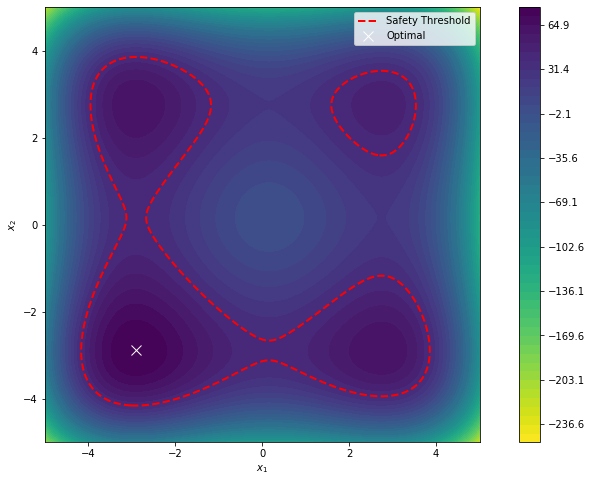

In [2]:
x_opt = fun.get_optimal_x()
y_opt = fun.get_optimal_y()
print(f'y_opt = {y_opt}, x_opt = {x_opt}')

fig, ax, legend = plot_function(fun.x_1, fun.x_2, fun.y, fun.safe_threshold)
plot_optimal(x_opt, fig, ax, legend)
plt.show()

Safe seeds:
 X = [[ 1.61322645 -2.61523046]
 [ 1.33266533 -3.29659319]
 [-2.25450902  1.59318637]
 [-3.53707415  1.61322645]
 [ 3.29659319  2.5751503 ]]
 y = [[51.26504373]
 [45.42935774]
 [46.48291477]
 [44.06903367]
 [44.27275253]]
 idx = [ 59830  42816 164637 165073 189414]
Safe seeds:
 X = [[-3.49699399  1.61322645]]
 y = [[45.20083275]]


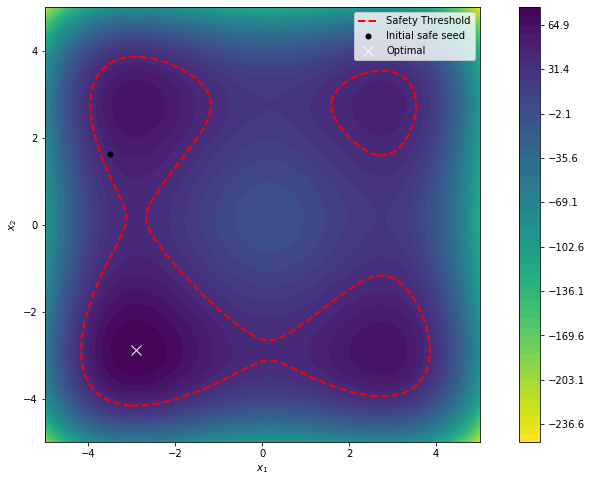

In [3]:
#Random selection (initial safe seed)
from numpy.random import default_rng
random_seed = 44
rng = default_rng(random_seed)
x_safe_seed, y_safe_seed = fun.get_uniform_safe_seeds(rng, n=5)
x_safe_seed, y_safe_seed = fun.get_default_safe_seeds(n=1)

fig, ax, legend = plot_function(fun.x_1, fun.x_2, fun.y, fun.safe_threshold)
fig, ax, legend = plot_safe_seed(x_safe_seed, fig, ax, legend)
plot_optimal(x_opt, fig, ax, legend)
plt.show()

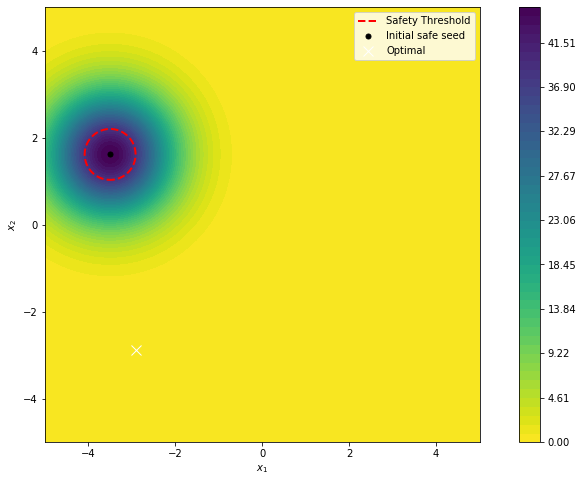

Lipschitz constant = 171.16132665329306


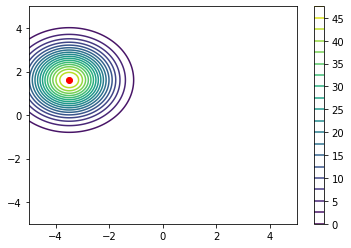

In [4]:
def run_safeopt(opt, fun, iterations, plot=False):
    for i in range(iterations):
        # Obtain next query point
        x_next = opt.optimize()
        # Get a measurement from the real system
        y_meas = fun(x_next)
        # Add this to the GP model
        opt.add_new_data_point(x_next, y_meas)
        print(f'evals={opt.t}\tx_next={x_next}\ty={y_meas}\tsafe={y_meas >= opt.fmin}')
        if plot: opt.plot(500)

def safeopt_stats(opt, fun):
    emax = opt.get_maximum()
    print(f'Estimated maximum = {emax} true_y = {fun(emax[0])}')
    print(f'Max found: {np.max(opt.y)}')
    print(f'Number of failures: {np.sum(opt.y < opt.fmin)} ({fun.n_unsafe})')
    
# Measurement noise, I will add the variance soon
noise_var = 0
# Define Kernel (2-dimensional RBF kernel)
kernel = GPy.kern.RBF(input_dim=fun.xdim, ARD=True)
#kernel = GPy.kern.Matern52(fun.xdim,ARD=True)
# The statistical model of our objective function
gp = GPy.models.GPRegression(x_safe_seed, y_safe_seed, kernel=kernel, noise_var=noise_var)
# The optimization routine
# FIXME: Why beta = 1.96 ?
mean, var = gp.predict_noiseless(fun.x_matrix)
fig, ax, legend = plot_function(fun.x_1, fun.x_2, mean, fun.safe_threshold)
fig, ax, legend = plot_safe_seed(x_safe_seed, fig, ax, legend)
plot_optimal(x_opt, fig, ax, legend)
plt.show()
opt = safeopt.SafeOpt(gp, parameter_set=fun.x_matrix, fmin=fun.safe_threshold, lipschitz=fun.lipschitz, beta = 2, threshold=0)
# here, use lipschitz=None for modified safeopt
#opt = safeopt.SafeOpt(gp, parameter_set=fun.x_matrix, fmin=fun.safe_threshold, lipschitz=None, beta = 2, threshold=0)
#opt = safeopt.SafeOpt(gp, parameter_set=fun.x_matrix, fmin=[fun.safe_threshold], lipschitz=None, beta = 1.96)
# Plot initial safe seed
opt.plot(500)

evals=2	x_next=[-3.55711423  1.55310621]	y=42.57243295690093	safe=[ True]
evals=3	x_next=[-3.03607214  2.05410822]	y=58.56685442328236	safe=[ True]
evals=4	x_next=[-2.41482966  1.43286573]	y=46.4207169898311	safe=[ True]
evals=5	x_next=[-2.75551102  1.9739479 ]	y=57.45154056830286	safe=[ True]
evals=6	x_next=[-2.95591182  2.21442886]	y=60.788265375285164	safe=[ True]
evals=7	x_next=[-2.93587174  3.57715431]	y=50.70403475935855	safe=[ True]
evals=8	x_next=[-2.7755511   2.81563126]	y=63.853290082783914	safe=[ True]
evals=9	x_next=[-2.93587174  2.73547094]	y=64.17546193256209	safe=[ True]
evals=10	x_next=[-2.8757515   2.71543086]	y=64.16815543893523	safe=[ True]
evals=11	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]


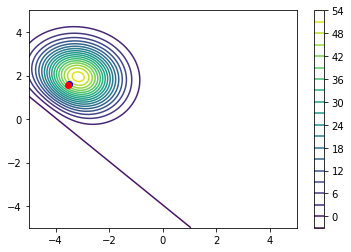

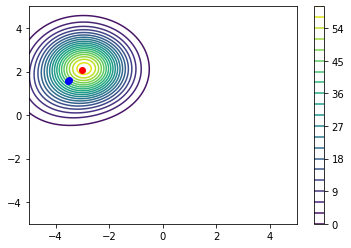

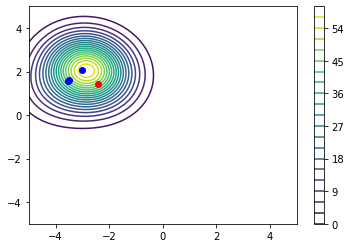

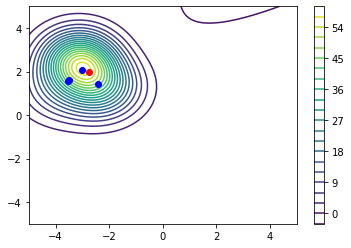

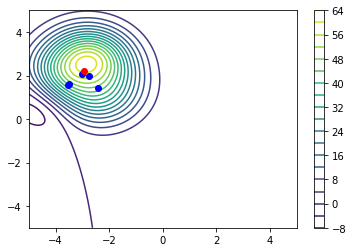

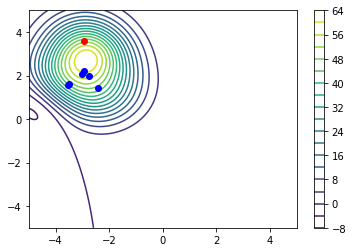

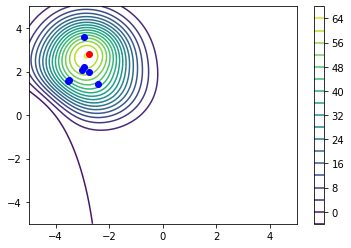

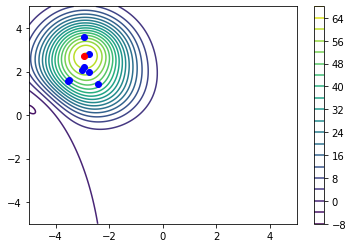

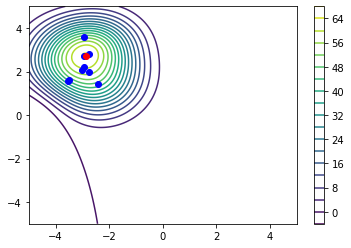

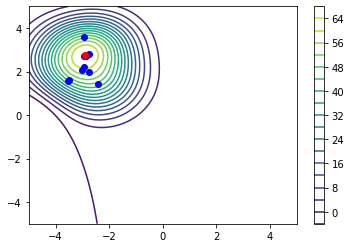

In [5]:
# do 10 iterations
run_safeopt(opt, fun, 10, plot=True)

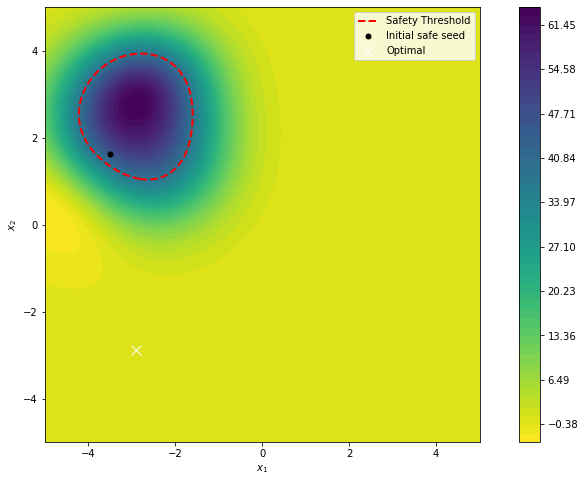

In [6]:
mean, var = gp.predict_noiseless(fun.x_matrix)
fig, ax, legend = plot_function(fun.x_1, fun.x_2, mean, fun.safe_threshold)
fig, ax, legend = plot_safe_seed(x_safe_seed, fig, ax, legend)
plot_optimal(x_opt, fig, ax, legend)
plt.show()

Estimated maximum = (array([-2.89579158,  2.73547094]), 64.19342506011664) true_y = 64.19270723282858
Max found: 64.1934650649216
Number of failures: 0 (0)


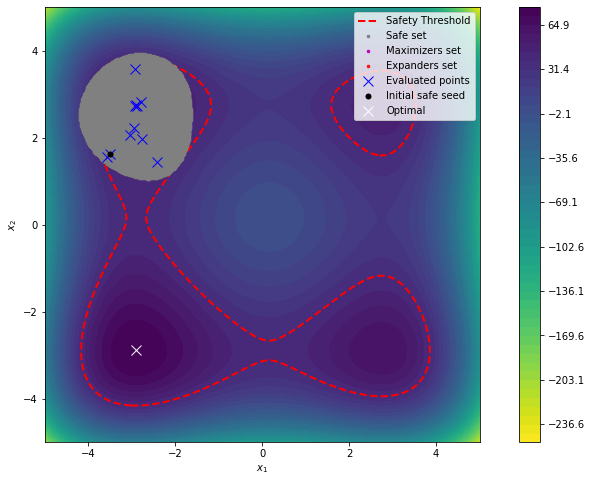

In [7]:
safeopt_stats(opt, fun)
plot_all(fun, opt, x_safe_seed, x_opt)

evals=12	x_next=[-2.89579158  2.73547094]	y=64.19270723282858	safe=[ True]
evals=13	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]
evals=14	x_next=[-2.89579158  2.73547094]	y=64.19270723282858	safe=[ True]
evals=15	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]
evals=16	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]
evals=17	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]
evals=18	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]
evals=19	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]
evals=20	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]
evals=21	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]
evals=22	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]
evals=23	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]
evals=24	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]
evals=25	x_next=[-2.89579158  2.7555

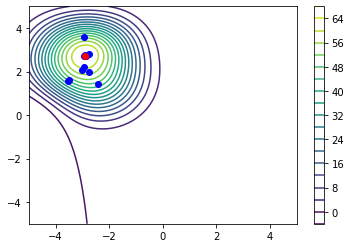

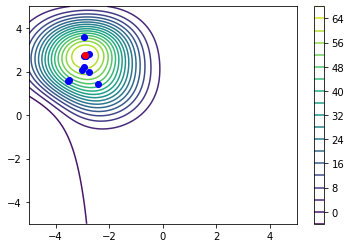

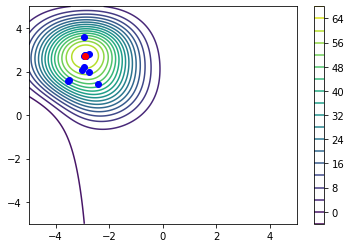

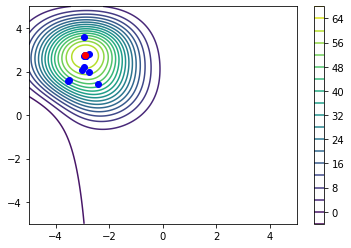

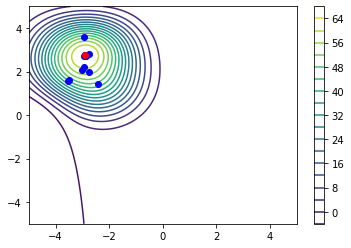

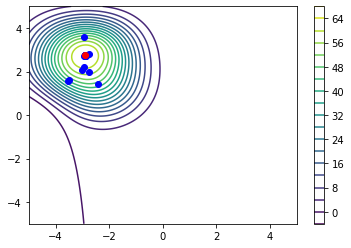

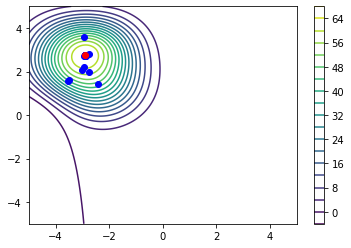

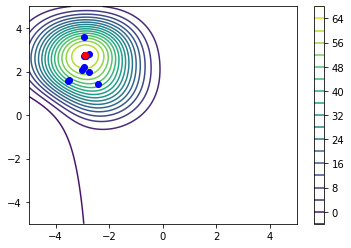

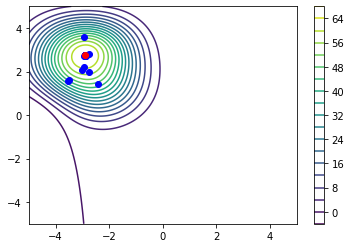

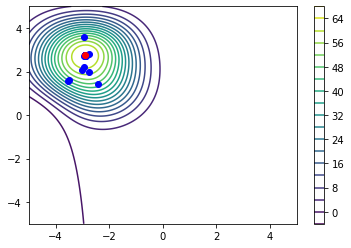

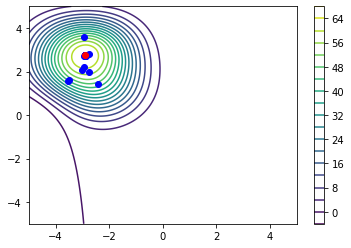

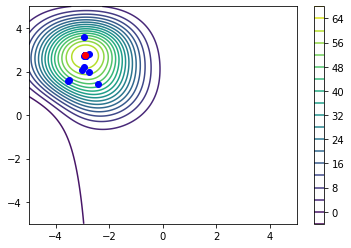

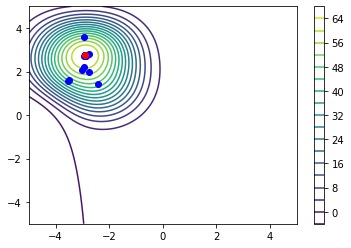

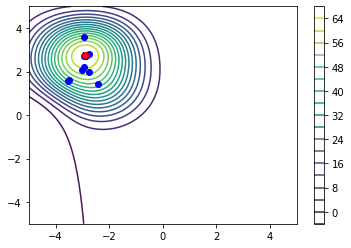

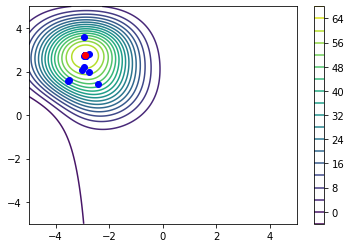

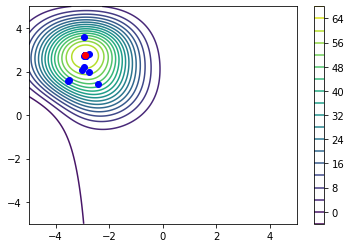

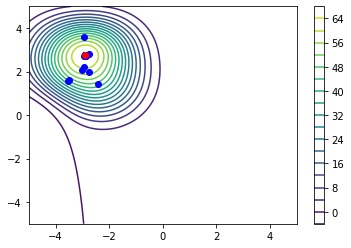

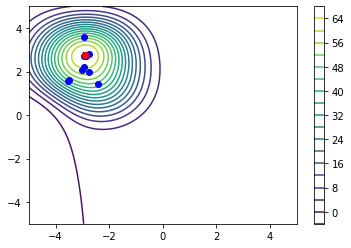

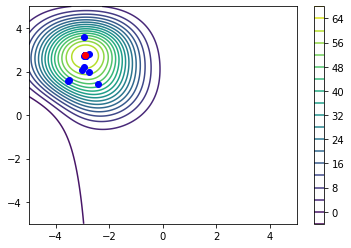

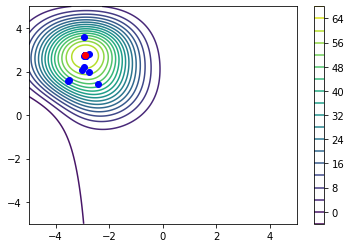

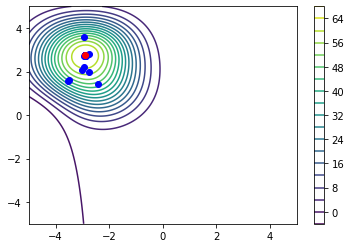

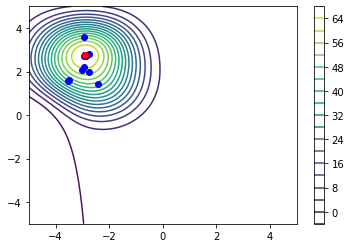

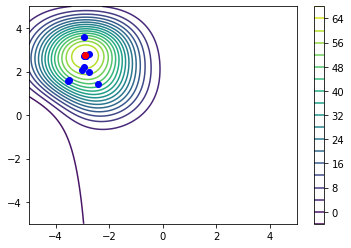

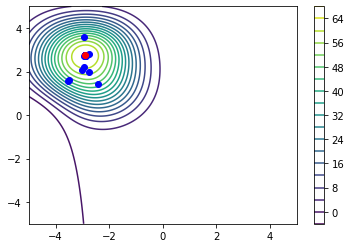

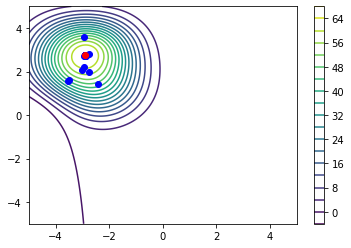

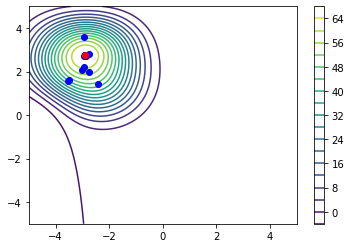

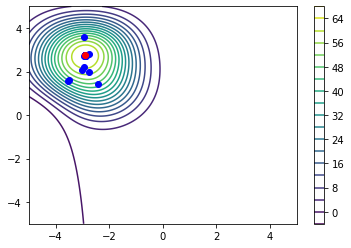

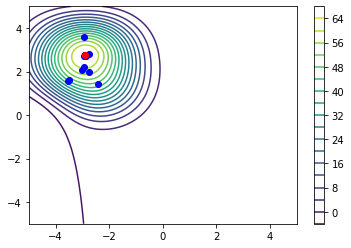

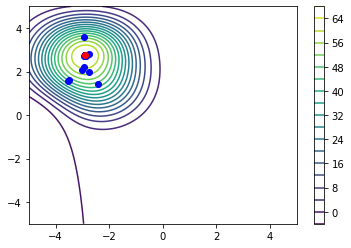

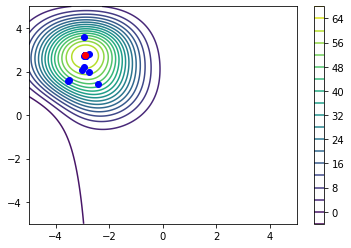

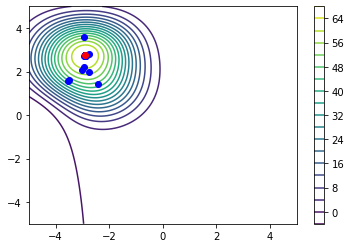

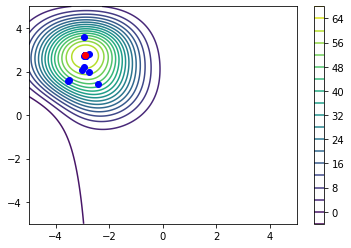

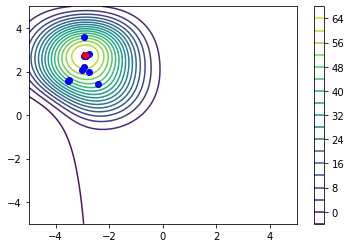

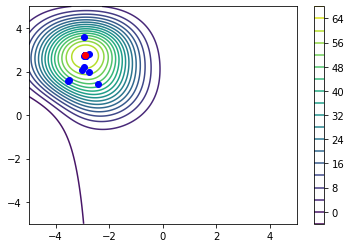

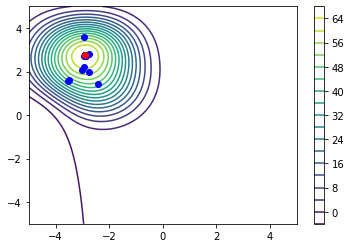

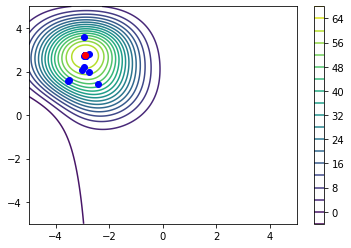

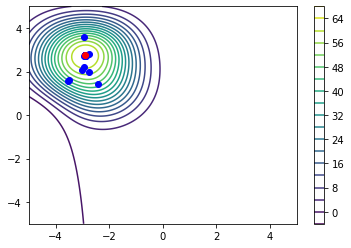

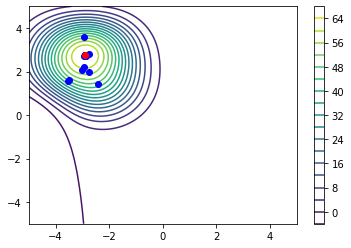

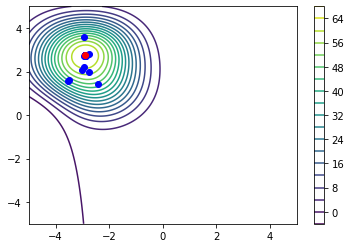

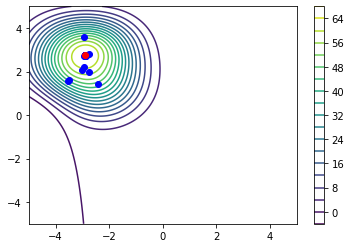

In [8]:
# do 40 more iterations (so far, 50 iterations)
run_safeopt(opt, fun, 40, plot=True)

Estimated maximum = (array([-2.89579158,  2.75551102]), 64.19342639037403) true_y = 64.1934650649216
Max found: 64.1934650649216
Number of failures: 0 (0)


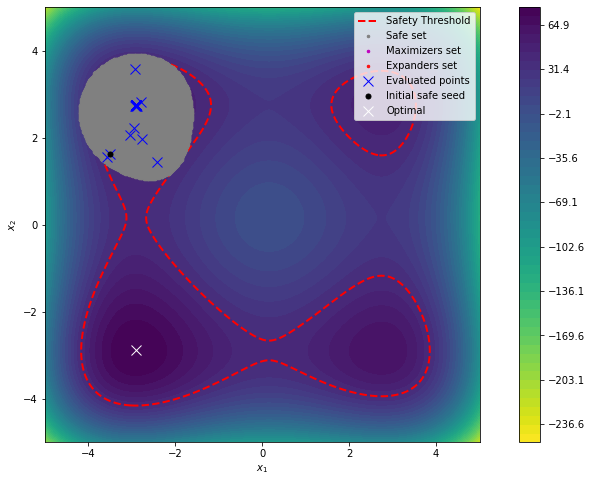

In [9]:
safeopt_stats(opt, fun)
plot_all(fun, opt, x_safe_seed, x_opt)

In [10]:
#do 60 iterations (so far 100 iterations)
run_safeopt(opt, fun, 60, plot=False) # This is very slow!

evals=52	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]
evals=53	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]
evals=54	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]
evals=55	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]
evals=56	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]
evals=57	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]
evals=58	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]
evals=59	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]
evals=60	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]
evals=61	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]
evals=62	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]
evals=63	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]
evals=64	x_next=[-2.89579158  2.75551102]	y=64.1934650649216	safe=[ True]
evals=65	x_next=[-2.89579158  2.755511

KeyboardInterrupt: 

In [ ]:
safeopt_stats(opt, fun)
plot_all(fun, opt, x_safe_seed, x_opt)
mean,  var = gp.predict_noiseless(fun.x_matrix)
fig, ax, legend = plot_function(fun.x_1, fun.x_2, mean, fun.safe_threshold)
fig, ax, legend = plot_safe_seed(x_safe_seed, fig, ax, legend)
plot_optimal(x_opt, fig, ax, legend)
plt.show()